# Projeto Final - Leukemia Classification
Nome: Bruno Mingoti

Matrícula: 20204165

## Instalações

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/codes/projeto2/data

/content/drive/MyDrive/codes/projeto2/data


In [ ]:
# ! pip install -q kaggle

In [ ]:
# from google.colab import files

In [ ]:
# files.upload()

In [ ]:
# ! mkdir ~/.kaggle

In [ ]:
# ! cp kaggle.json ~/.kaggle/

In [ ]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets download avk256/cnmc-leukemia

100% 598M/598M [00:20<00:00, 40.3MB/s]
100% 598M/598M [00:20<00:00, 30.1MB/s]


In [ ]:
# ! unzip cnmc-leukemia.zip -d /content/drive/MyDrive/codes/projeto/data

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/drive/MyDrive/codes/projeto/data/fold_1/fold_1/all/UID_51_44_2_all.bmp  
  inflating: /content/drive/MyDrive/codes/projeto/data/fold_1/fold_1/all/UID_51_44_3_all.bmp  
  inflating: /content/drive/MyDrive/codes/projeto/data/fold_1/fold_1/all/UID_51_44_4_all.bmp  
  inflating: /content/drive/MyDrive/codes/projeto/data/fold_1/fold_1/all/UID_51_44_5_all.bmp  
  inflating: /content/drive/MyDrive/codes/projeto/data/fold_1/fold_1/all/UID_51_44_6_all.bmp  
  inflating: /content/drive/MyDrive/codes/projeto/data/fold_1/fold_1/all/UID_51_44_7_all.bmp  
  inflating: /content/drive/MyDrive/codes/projeto/data/fold_1/fold_1/all/UID_51_44_8_all.bmp  
  inflating: /content/drive/MyDrive/codes/projeto/data/fold_1/fold_1/all/UID_51_46_1_all.bmp  
  inflating: /content/drive/MyDrive/codes/projeto/data/fold_1/fold_1/all/UID_51_46_2_all.bmp  
  inflating: /content/drive/MyDrive/codes/projeto/data/fold_1/fold_1/all/UID_51_46_3_a

In [3]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-61zei2_z
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-61zei2_z
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20031 sha256=25633ca96413ed90a0f4c3695f3ffeaf45052a78612fa71c61cefb57edd6e3ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-5t581_60/wheels/f5/13/cb/b1dbd79043c5a389742e422859b0b663adcd7b5c220928c339
Successfully built image-classifiers


In [4]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 4.7 MB/s eta 0:00:00


In [5]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 13.4 MB/s eta 0:00:00


## Importações

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from sklearn.utils import class_weight
from tensorflow.keras.metrics import AUC
import tensorflow as tf

from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import InputLayer, Reshape, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, RandomRotation, RandomFlip, RandomTranslation, Rescaling, GlobalAveragePooling2D, RandomCrop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import math
from classification_models.keras import Classifiers
import tensorflow_addons as tfa
from tensorflow.keras.optimizers.experimental import SGD
import xgboost as xgb
from tensorflow.image import rgb_to_hsv
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.image import resize_with_crop_or_pad
from tensorflow import cast
from sklearn.utils import class_weight
from matplotlib import cm
from tf_keras_vis.utils.scores import BinaryScore, CategoricalScore
from tf_keras_vis.scorecam import Scorecam
import time
import keras
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from keras.models import load_model


# Modelos
## ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet50_preprocess

## InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as InceptionResNetV2_preprocess

## VGG16
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as VGG16_preprocess

## InceptionV3
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as InceptionV3_preprocess


## Funções

In [8]:
# Plota a matriz de confusão
def plot_confusion_matrix(ds_test, classes, y_test, y_pred):
    plt.figure(figsize=(12, 8))
    ax= plt.subplot()
    mconf = confusion_matrix(y_test, y_pred)
    sns.heatmap(mconf, annot=True, fmt='d', cmap='icefire', ax=ax)
    ax.set_title("Matriz de confusão");
    img_labels = classes
    ax.xaxis.set_ticklabels(img_labels);
    ax.yaxis.set_ticklabels(img_labels);
    ax.set_xlabel('Predição');ax.set_ylabel('Real');


# Cria o dataset e aplica o pré-processamento com base nos valores passados como parâmetro da função
def create_dataset(dataframe, img_size=None, batch_size=16, to_hsv=False, center_crop_height=None, center_crop_width=None):

    paths = dataframe['full_path']
    labels = dataframe['label']
    labels = tf.one_hot(labels, depth=n_classes)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: (tf.io.read_file(x), y))
    ds = ds.map(lambda x, y: (tf.io.decode_bmp(x, channels=3), y))

    # Recorta a imagem para o ponto especificado
    if center_crop_height is not None and center_crop_width is not None:
        ds = ds.map(lambda x, y: (tf.keras.layers.CenterCrop(center_crop_height, center_crop_width)(x), y))

    # Redimensiona a imagem
    ds = ds.map(lambda x, y: (tf.image.resize(x, img_size, method='bicubic'), y))

    # Converte imagem de RGB para HSV
    if to_hsv:
        ds = ds.map(lambda x, y: (rgb_to_hsv(tf.image.convert_image_dtype(x, tf.float32)), y))
    ds = ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


# Aplica o modelo com os pesos da imagenet e com as camadas descongeladas. Por fim aplica a camada de ativação softmax, comumente utilizada em outros trabalhos relacionados
def apply_model(arq, preprocess_input, data_augmentation=None, img_size=(299,299), pooling='avg', weights='imagenet'):
    input_shape = img_size + (3,)
    base_model = arq(include_top=False, input_shape=input_shape, pooling=pooling, weights=weights)
    base_model.trainable = True

    i = Input(shape=input_shape)
    if data_augmentation is not None:
        x = data_augmentation(i)
        x = preprocess_input(x)
    else:
        x = preprocess_input(i)


    x = base_model(x, training=True)
    x = Dense(n_classes, activation='softmax')(x)
    model = Model(i, x)
    return model


# Treina o modelo
def apply_train(model, ds_train, ds_val, epochs, callbacks, loss_function, lr, metrics=[AUC(), tfa.metrics.FBetaScore(num_classes=2, average='weighted')], optimizer=Adam, cls_weights=True):
    model.compile(loss=loss_function, metrics=metrics, optimizer=optimizer(learning_rate=lr))

    # Aplicação do class_weights, técnica para lidar com o dataset desbalanceado
    if cls_weights:
        neg, pos = np.bincount(df_train['label'])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)

        class_weight = {0: weight_for_0, 1: weight_for_1}
        history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks, class_weight=class_weight)
    else:
        history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks)

    return model, history


# Reduz as instâncias para criar o df_train_small. Esse será o dataset utilizado durante os testes intermediários
def reduzir_instancias_por_classe(df, nome_col, num_instancias_por_classe, print_info=False):
    df_temp = []
    variables = df[nome_col].unique()
    variables.sort()
    for classe in variables:
        temp = df[df[nome_col] == classe].sample(n=num_instancias_por_classe,
                                            random_state=42)

        df_temp.append(temp)
    small = pd.concat(df_temp, axis=0)
    if print_info:
        print('-'*30)
        print('#instâncias em relação a coluna name')
        print(small[nome_col].value_counts())
        print('-'*30)

    return small

## Preparação dos dados

In [9]:
all_0 = '/content/drive/MyDrive/codes/projeto2/data/fold_0/fold_0/all/'
hem_0 = '/content/drive/MyDrive/codes/projeto2/data/fold_0/fold_0/hem/'
all_1 = '/content/drive/MyDrive/codes/projeto2/data/fold_1/fold_1/all/'
hem_1 = '/content/drive/MyDrive/codes/projeto2/data/fold_1/fold_1/hem/'
all_2 = '/content/drive/MyDrive/codes/projeto2/data/fold_2/fold_2/all/'
hem_2 = '/content/drive/MyDrive/codes/projeto2/data/fold_2/fold_2/hem/'

In [10]:
image_paths = []
image_labels = []

for data_folder_path in [all_0,all_1,all_2,hem_0,hem_1,hem_2]:
    all_images_in_folder = os.listdir(data_folder_path)
    for image_path in all_images_in_folder:
        image_label = 1 if 'all' in data_folder_path else 0

        image_paths.append(data_folder_path + image_path)
        image_labels.append(image_label)

dict_train = {"full_path":image_paths, "label":image_labels}
df = pd.DataFrame(dict_train)

df

,full_path,label
0,/content/drive/MyDrive/codes/projeto2/data/fol...,1
1,/content/drive/MyDrive/codes/projeto2/data/fol...,1
2,/content/drive/MyDrive/codes/projeto2/data/fol...,1
3,/content/drive/MyDrive/codes/projeto2/data/fol...,1
4,/content/drive/MyDrive/codes/projeto2/data/fol...,1
...,...,...
10656,/content/drive/MyDrive/codes/projeto2/data/fol...,0
10657,/content/drive/MyDrive/codes/projeto2/data/fol...,0
10658,/content/drive/MyDrive/codes/projeto2/data/fol...,0
10659,/content/drive/MyDrive/codes/projeto2/data/fol...,0


In [11]:
classes = list(df['label'].unique())
n_classes = len(classes)

## EDA

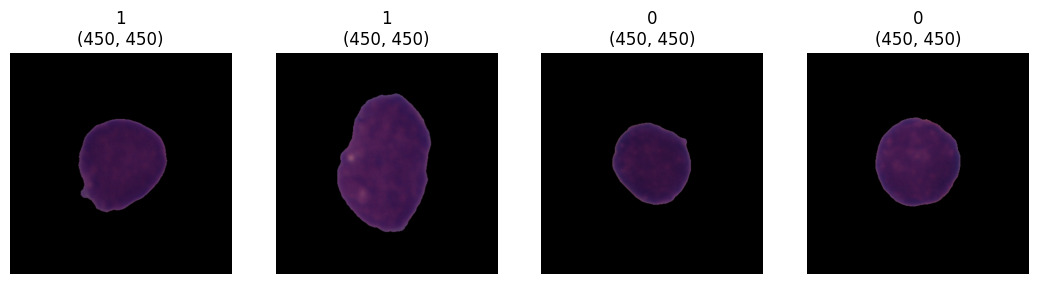

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 16))
for i, label in enumerate(classes):
    subset = df['full_path'][df['label'] == label].sample(2, random_state=42)
    for j in range(2):
        plt.subplot(4, 6, 2*i+j+1)
        img = plt.imread(subset.iloc[j])
        plt.imshow(img)
        plt.title(f'{label}\n{img.shape[:2]}')
        plt.axis('off')

1    7272
0    3389
Name: label, dtype: int64

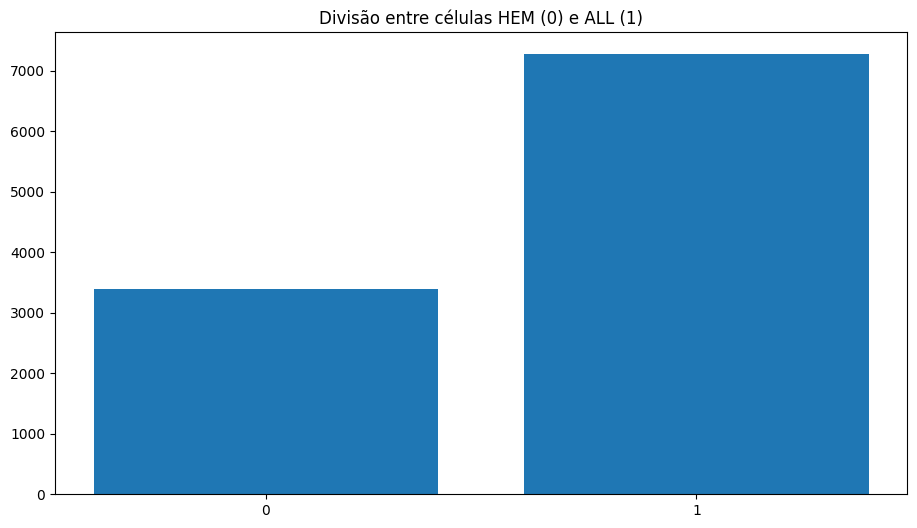

In [ ]:
plt.figure(figsize=(11,6))
div = df['label'].value_counts()
plt.bar(list(div.index), div)
plt.xticks(range(0, 2))
plt.title('Divisão entre células HEM (0) e ALL (1)');
div

**Problema:** Há um desbalanceamento das classes. Para tal será abordado algumas técnica posteriormentes para contornar esse problema.

## Separação dos conjuntos de treino, validação e teste

In [12]:
df_train = pd.read_csv('df_train.csv')
df_val = pd.read_csv('df_val.csv')
df_test = pd.read_csv('df_test.csv')
df_train_small = pd.read_csv('df_train_small.csv')

In [12]:
df_train, df_val_test = train_test_split(df, test_size=0.25, stratify = df['label'], random_state=42)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, stratify = df_val_test['label'], random_state=42)
df_train_small, _ = train_test_split(df_train, train_size=250*n_classes, stratify=df_train['label'], random_state=42)

In [13]:
# Salvamento dos dataframes gerados na célula acima, de forma a possibilitar testes isolados, se necessário, sem que ocorra vazamento de dados.

# df_train.to_csv('df_train.csv', index=False)
# df_val.to_csv('df_val.csv', index=False)
# df_test.to_csv('df_test.csv', index=False)
# df_train_small.to_csv('df_train_small.csv', index=False)

In [ ]:
print('-'*30)
print('datasets division')
print('-'*30)
print(f'# train (small) = {len(df_train_small)}')
print(f'# train (full)  = {len(df_train)}')
print(f'# val           = {len(df_val)}')
print(f'# test          = {len(df_test)}')

------------------------------
datasets division
------------------------------
# train (small) = 500
# train (full)  = 7995
# val           = 1333
# test          = 1333


O primeiro método aplicado para lidar com o dataset desbalanceado foi aplicar uma divisão estratificada dos conjuntos de dados, tendo a classe como variável controle do processo de estratificação, garantindo, assim, que a classe minoritária tenha oportunidade de estar nos conjuntos de treino, de validação e de teste.

Para a escolha de uma métrica confiável, foi adotado o weighted F1-Score, convencionalmente utilizada como a principal métrica em trabalhos relacionados. Além disso, AUC também pode ser utilizado como métrica auxiliar.

## Criação dos datasets

In [13]:
callbacks = [ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)]
epochs = 10
lr = 0.0001
img_size = (299,299)
batch_size = 16

ds_train = create_dataset(df_train, img_size, batch_size, center_crop_height=448, center_crop_width=448)
ds_val = create_dataset(df_val, img_size, batch_size, center_crop_height=448, center_crop_width=448)
ds_test = create_dataset(df_test, img_size, batch_size, center_crop_height=448, center_crop_width=448)
ds_test_200 = create_dataset(df_test, (200, 200), 4, center_crop_height=448, center_crop_width=448)
ds_test_200_hsv = create_dataset(df_test, (200, 200), 4, to_hsv=True, center_crop_height=448, center_crop_width=448)
ds_train_small = create_dataset(df_train_small, img_size, batch_size, center_crop_height=448, center_crop_width=448)

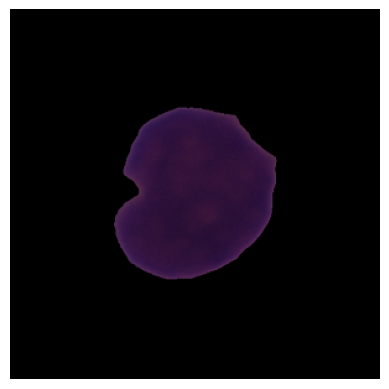

<_TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [ ]:
sample = ds_train.take(1)
for image, label in sample:
    image_np = image[0].numpy() / 255
    plt.imshow(image_np)
    plt.axis("off")
    plt.show()

sample

## Escolha da Arquitetura

### AlexNet

In [ ]:
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
                    loss='binary_crossentropy',
                    metrics=[AUC(), tfa.metrics.FBetaScore(num_classes=2, average='weighted')])

In [ ]:
input_shape = img_size + (3,)
alexnet_model = AlexNet(input_shape, n_classes)

In [ ]:
start_time = time.time()
alexnet_history = alexnet_model.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks)
training_time_alexnet = time.time() - start_time

Epoch 1/10
32/32 [==============================] - 243s 7s/step - loss: 45.3645 - auc_2: 0.6712 - fbeta_score: 0.6534 - val_loss: 0.7983 - val_auc_2: 0.8470 - val_fbeta_score: 0.7858 - lr: 1.0000e-04
Epoch 2/10
32/32 [==============================] - 4s 112ms/step - loss: 0.6222 - auc_2: 0.8345 - fbeta_score: 0.7829 - val_loss: 0.6247 - val_auc_2: 0.8274 - val_fbeta_score: 0.7193 - lr: 1.0000e-04
Epoch 3/10
32/32 [==============================] - 4s 115ms/step - loss: 0.3845 - auc_2: 0.9089 - fbeta_score: 0.8075 - val_loss: 0.5258 - val_auc_2: 0.8525 - val_fbeta_score: 0.7748 - lr: 1.0000e-04
Epoch 4/10
32/32 [==============================] - 3s 109ms/step - loss: 0.2722 - auc_2: 0.9588 - fbeta_score: 0.8844 - val_loss: 0.5281 - val_auc_2: 0.8543 - val_fbeta_score: 0.7788 - lr: 1.0000e-04
Epoch 5/10
32/32 [==============================] - 4s 114ms/step - loss: 0.1669 - auc_2: 0.9895 - fbeta_score: 0.9339 - val_loss: 0.5648 - val_auc_2: 0.8539 - val_fbeta_score: 0.7868 - lr: 1.0000

### InceptionV3

In [ ]:
inceptionv3_model = apply_model(InceptionV3, InceptionV3_preprocess)
start_time = time.time()
inceptionv3_model, inceptionv3_history = apply_train(inceptionv3_model, ds_train_small, ds_val, epochs, callbacks, 'BinaryCrossentropy', lr)
training_time_inceptionv3 = time.time() - start_time

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/10
32/32 [==============================] - 68s 648ms/step - loss: 0.5452 - auc_1: 0.7998 - fbeta_score: 0.7208 - val_loss: 0.4336 - val_auc_1: 0.9016 - val_fbeta_score: 0.8311 - lr: 1.0000e-04
Epoch 2/10
32/32 [==============================] - 13s 427ms/step - loss: 0.2111 - auc_1: 0.9767 - fbeta_score: 0.9129 - val_loss: 0.4028 - val_auc_1: 0.9045 - val_fbeta_score: 0.8418 - lr: 1.0000e-04
Epoch 3/10
32/32 [==============================] - 13s 418ms/step - loss: 0.0839 - auc_1: 0.9935 - fbeta_score: 0.9801 - val_loss: 0.4601 - val_auc_1: 0.8982 - val_fbeta_score: 0.8460 - lr: 1.0000e-04
Epoch 4/10
32/32 [==============================] - 13s 420ms/step - loss: 0.0698 - auc_1: 0.9967 - fbeta_score: 0.9861 - val_loss: 0.4126 - val_auc_1: 0.9187 - val_fbeta_score: 0.8570 - lr: 1.0000e-04
Epoch 5/10
32/32 [==============================] - ETA: 0s - loss: 0.0945 - auc_1: 0.9952 - fbeta_score: 0.9662
Epoch 5: Reduc

### InceptionResNetV2

In [ ]:
InceptionResNetV2_model = apply_model(InceptionResNetV2, InceptionResNetV2_preprocess)
start_time = time.time()
InceptionResNetV2_model, InceptionResNetV2_history = apply_train(InceptionResNetV2_model, ds_train_small, ds_val, epochs, callbacks, 'BinaryCrossentropy', lr)
training_time_inceptionresnetv2 = time.time() - start_time

219055592/219055592 [==============================] - 3s 0us/step
Epoch 1/10
32/32 [==============================] - 144s 1s/step - loss: 0.5356 - auc_1: 0.8879 - fbeta_score: 0.8260 - val_loss: 0.4281 - val_auc_1: 0.8939 - val_fbeta_score: 0.8232 - lr: 1.0000e-04
Epoch 2/10
32/32 [==============================] - 32s 1s/step - loss: 0.2580 - auc_1: 0.9637 - fbeta_score: 0.8944 - val_loss: 0.3921 - val_auc_1: 0.9046 - val_fbeta_score: 0.8337 - lr: 1.0000e-04
Epoch 3/10
32/32 [==============================] - 38s 1s/step - loss: 0.1207 - auc_1: 0.9917 - fbeta_score: 0.9544 - val_loss: 0.5950 - val_auc_1: 0.8665 - val_fbeta_score: 0.8142 - lr: 1.0000e-04
Epoch 4/10
32/32 [==============================] - 38s 1s/step - loss: 0.1206 - auc_1: 0.9893 - fbeta_score: 0.9601 - val_loss: 0.5344 - val_auc_1: 0.8789 - val_fbeta_score: 0.8300 - lr: 1.0000e-04
Epoch 5/10
32/32 [==============================] - ETA: 0s - loss: 0.0784 - auc_1: 0.9963 - fbeta_score: 0.9800
Epoch 5: ReduceLROnPlat

### VGG16

In [ ]:
VGG16_model = apply_model(VGG16, VGG16_preprocess)
start_time = time.time()
VGG16_model, VGG16_history = apply_train(VGG16_model, ds_train_small, ds_val, epochs, callbacks, 'BinaryCrossentropy', lr)
training_time_vgg16 = time.time() - start_time

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
32/32 [==============================] - 45s 909ms/step - loss: 0.7241 - auc_1: 0.8587 - fbeta_score: 0.7840 - val_loss: 0.6077 - val_auc_1: 0.8221 - val_fbeta_score: 0.5539 - lr: 1.0000e-04
Epoch 2/10
32/32 [==============================] - 22s 696ms/step - loss: 0.6634 - auc_1: 0.7739 - fbeta_score: 0.7111 - val_loss: 0.5268 - val_auc_1: 0.8243 - val_fbeta_score: 0.5539 - lr: 1.0000e-04
Epoch 3/10
32/32 [==============================] - 22s 696ms/step - loss: 0.5703 - auc_1: 0.8232 - fbeta_score: 0.7489 - val_loss: 0.5249 - val_auc_1: 0.8577 - val_fbeta_score: 0.7938 - lr: 1.0000e-04
Epoch 4/10
32/32 [==============================] - 22s 700ms/step - loss: 0.5393 - auc_1: 0.8454 - fbeta_score: 0.7897 - val_loss: 0.5140 - val_auc_1: 0.8577 - val_fbeta_score: 0.7907 - lr: 1.0000e-04
Epoch 5/10
32/32 [==============================] - 22s 694ms/step - loss: 0.4719 - auc_1: 0.8629 - fbeta_score: 0.7980 - val_l

### ResNet18

In [ ]:
ResNet18, ResNet18_preprocess = Classifiers.get('resnet18')
resnet18_model = ResNet18(input_shape=img_size + (3,), classes=n_classes)
start_time = time.time()
resnet18_model, resnet18_history = apply_train(resnet18_model, ds_train_small, ds_val, epochs, callbacks, 'BinaryCrossentropy', lr)
training_time_resnet18 = time.time() - start_time

Epoch 1/10
32/32 [==============================] - 23s 282ms/step - loss: 0.5600 - auc_1: 0.8308 - fbeta_score: 0.7584 - val_loss: 17.8541 - val_auc_1: 0.3173 - val_fbeta_score: 0.1529 - lr: 1.0000e-04
Epoch 2/10
32/32 [==============================] - 7s 216ms/step - loss: 0.3213 - auc_1: 0.9336 - fbeta_score: 0.8598 - val_loss: 9.5750 - val_auc_1: 0.3173 - val_fbeta_score: 0.1529 - lr: 1.0000e-04
Epoch 3/10
32/32 [==============================] - 7s 221ms/step - loss: 0.1180 - auc_1: 0.9885 - fbeta_score: 0.9703 - val_loss: 21.6802 - val_auc_1: 0.3173 - val_fbeta_score: 0.1529 - lr: 1.0000e-04
Epoch 4/10
32/32 [==============================] - 7s 218ms/step - loss: 0.1398 - auc_1: 0.9852 - fbeta_score: 0.9409 - val_loss: 2.7929 - val_auc_1: 0.4077 - val_fbeta_score: 0.2904 - lr: 1.0000e-04
Epoch 5/10
32/32 [==============================] - 7s 221ms/step - loss: 0.0893 - auc_1: 0.9947 - fbeta_score: 0.9742 - val_loss: 0.6332 - val_auc_1: 0.8073 - val_fbeta_score: 0.7635 - lr: 1.0

In [ ]:
info_df = pd.DataFrame(columns=['Arquitetura', 'Train F1 Score', 'Val F1 Score', 'Train AUC', 'Val AUC', 'Training Time' ])

info_df['Arquitetura'] = ['AlexNet', 'InceptionV3', 'InceptionResNetV2', 'VGG16', 'ResNet18']
info_df['Train F1 Score'] = [f"{alexnet_history.history['fbeta_score'][-1] * 100:.2f}%",
                               f"{inceptionv3_history.history['fbeta_score'][-1] * 100:.2f}%",
                               f"{InceptionResNetV2_history.history['fbeta_score'][-1] * 100:.2f}%",
                                f"{VGG16_history.history['fbeta_score'][-1] * 100:.2f}%",
                              f"{resnet18_history.history['fbeta_score'][-1] * 100:.2f}%",]


info_df['Val F1 Score'] = [f"{alexnet_history.history['val_fbeta_score'][-1] * 100:.2f}%",
                               f"{inceptionv3_history.history['val_fbeta_score'][-1] * 100:.2f}%",
                               f"{InceptionResNetV2_history.history['val_fbeta_score'][-1] * 100:.2f}%",
                               f"{VGG16_history.history['val_fbeta_score'][-1] * 100:.2f}%",
                              f"{resnet18_history.history['val_fbeta_score'][-1] * 100:.2f}%",]


info_df['Train AUC'] = [f"{alexnet_history.history['auc_2'][-1] * 100:.2f}%",
                               f"{inceptionv3_history.history['auc_1'][-1] * 100:.2f}%",
                               f"{InceptionResNetV2_history.history['auc_1'][-1] * 100:.2f}%",
                                f"{VGG16_history.history['auc_1'][-1] * 100:.2f}%",
                              f"{resnet18_history.history['auc_1'][-1] * 100:.2f}%",]


info_df['Val AUC'] = [f"{alexnet_history.history['val_auc_2'][-1] * 100:.2f}%",
                               f"{inceptionv3_history.history['val_auc_1'][-1] * 100:.2f}%",
                               f"{InceptionResNetV2_history.history['val_auc_1'][-1] * 100:.2f}%",
                                f"{VGG16_history.history['val_auc_1'][-1] * 100:.2f}%",
                              f"{resnet18_history.history['val_auc_1'][-1] * 100:.2f}%",]


info_df['Training Time'] = [f"{int(training_time_alexnet)} s",
                              f"{int(training_time_inceptionv3)} s",
                             f"{int(training_time_inceptionresnetv2)} s",
                            f"{int(training_time_vgg16)} s",
                             f"{int(training_time_resnet18)} s",]


info_df.set_index('Arquitetura')

,Train F1 Score,Val F1 Score,Train AUC,Val AUC,Training Time
Arquitetura,,,,,
AlexNet,100.00%,80.07%,100.00%,85.13%,277 s
InceptionV3,100.00%,86.03%,100.00%,90.44%,224 s
InceptionResNetV2,100.00%,84.44%,100.00%,89.83%,479 s
VGG16,87.85%,76.79%,94.98%,85.25%,319 s
ResNet18,100.00%,79.17%,100.00%,83.23%,96 s


**Melhor Arquitetura:** InceptionV3

Será utilizada essa arquitetura no restante do notebook.

## Sem class weights

A aplicação do class-weights foi pensada como um segundo método para lidar com o desbalancemaneto de dados. Tal função possibilita que o modelo “preste mais atenção” aos exemplos de uma classe sub-representada, nesse caso a classe referente às células HEM.

In [ ]:
inceptionv3_without_cls_weights_model = apply_model(InceptionV3, InceptionV3_preprocess)
inceptionv3_without_cls_weights_model, inceptionv3_without_cls_weights_history = apply_train(inceptionv3_without_cls_weights_model, ds_train_small, ds_val, epochs, callbacks, 'BinaryCrossentropy', lr, cls_weights=False)

Epoch 1/10
32/32 [==============================] - 60s 609ms/step - loss: 0.4894 - auc_1: 0.8322 - fbeta_score: 0.7881 - val_loss: 0.3791 - val_auc_1: 0.9109 - val_fbeta_score: 0.8380 - lr: 1.0000e-04
Epoch 2/10
32/32 [==============================] - 13s 423ms/step - loss: 0.1866 - auc_1: 0.9810 - fbeta_score: 0.9314 - val_loss: 0.4459 - val_auc_1: 0.8888 - val_fbeta_score: 0.8074 - lr: 1.0000e-04
Epoch 3/10
32/32 [==============================] - 13s 427ms/step - loss: 0.0958 - auc_1: 0.9951 - fbeta_score: 0.9740 - val_loss: 0.4952 - val_auc_1: 0.8943 - val_fbeta_score: 0.8429 - lr: 1.0000e-04
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 0.1203 - auc_1: 0.9881 - fbeta_score: 0.9618
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
32/32 [==============================] - 13s 426ms/step - loss: 0.1203 - auc_1: 0.9881 - fbeta_score: 0.9618 - val_loss: 0.4889 - val_auc_1: 0.8947 - val_fbeta_score: 0.8203 - lr: 1.0000e-04
Epoch 5/10
32

In [ ]:
info_df_class_weights = pd.DataFrame(columns=['Arquitetura InceptionV3', 'Train F1 Score', 'Val F1 Score', 'Train AUC', 'Val AUC'])

info_df_class_weights['Arquitetura InceptionV3'] = ['Sem class_weights', 'Com class_weights']
info_df_class_weights['Train F1 Score'] = [f"{inceptionv3_without_cls_weights_history.history['fbeta_score'][-1] * 100:.2f}%",
                               f"{inceptionv3_history.history['fbeta_score'][-1] * 100:.2f}%",]


info_df_class_weights['Val F1 Score'] = [f"{inceptionv3_without_cls_weights_history.history['val_fbeta_score'][-1] * 100:.2f}%",
                               f"{inceptionv3_history.history['val_fbeta_score'][-1] * 100:.2f}%",]


info_df_class_weights['Train AUC'] = [f"{inceptionv3_without_cls_weights_history.history['auc_1'][-1] * 100:.2f}%",
                               f"{inceptionv3_history.history['auc_1'][-1] * 100:.2f}%",]


info_df_class_weights['Val AUC'] = [f"{inceptionv3_without_cls_weights_history.history['val_auc_1'][-1] * 100:.2f}%",
                               f"{inceptionv3_history.history['val_auc_1'][-1] * 100:.2f}%",]


info_df_class_weights.set_index('Arquitetura InceptionV3')

,Train F1 Score,Val F1 Score,Train AUC,Val AUC
Arquitetura InceptionV3,,,,
Sem class_weights,100.00%,84.53%,100.00%,89.55%
Com class_weights,100.00%,86.03%,100.00%,90.44%


**Melhor Modelo:** Com class_weights

Será utilizada essa arquitetura no restante do notebook.

## Data Augmentation

In [14]:
data_augmentation = Sequential(
    [
     RandomFlip('horizontal_and_vertical'),
     RandomRotation(0.3),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.Lambda(lambda x: tfa.image.random_cutout(x, mask_size=32)),
    ],
    name='data_augmentation'
)

# Aplicação do data augmentation com as seguintes técnicas:

# Flips horizontais e verticais, cada um com 50% de probabilidade de ocorrência;
# Rotações aleatórias com fator 0.3, ou seja, as rotações ocorrem no intervalo [-30%*2π,30%*2π] (função RandomRotation do TensorFlow);
# Translações aleatórias com fator de 20% na altura e largura da imagem (função RandomTranslation do TensorFlow);
# Recortes retangulares aleatórios (função random_cutout do TensorFlow Addons);


In [ ]:
ds_train_augmentation = create_dataset(df_train, img_size, batch_size, center_crop_height=448, center_crop_width=448)
ds_val_augmentation = create_dataset(df_val, img_size, batch_size, center_crop_height=448, center_crop_width=448)
ds_train_small_augmentation = create_dataset(df_train_small, img_size, batch_size, center_crop_height=448, center_crop_width=448)

In [ ]:
inceptionv3_augmentation_model = apply_model(InceptionV3, InceptionV3_preprocess, data_augmentation)
start_time = time.time()
inceptionv3_augmentation_model, inceptionv3_augmentation_history = apply_train(inceptionv3_augmentation_model, ds_train_small_augmentation, ds_val_augmentation, epochs, callbacks, 'BinaryCrossentropy', lr)
training_time_1 = time.time() - start_time

Epoch 1/10
32/32 [==============================] - 88s 958ms/step - loss: 0.5424 - auc: 0.8298 - fbeta_score: 0.7698 - val_loss: 0.4577 - val_auc: 0.8683 - val_fbeta_score: 0.8129 - lr: 1.0000e-04
Epoch 2/10
32/32 [==============================] - 15s 460ms/step - loss: 0.4141 - auc: 0.9006 - fbeta_score: 0.8461 - val_loss: 0.4001 - val_auc: 0.9012 - val_fbeta_score: 0.8359 - lr: 1.0000e-04
Epoch 3/10
32/32 [==============================] - 14s 455ms/step - loss: 0.3586 - auc: 0.9222 - fbeta_score: 0.8573 - val_loss: 0.4234 - val_auc: 0.8901 - val_fbeta_score: 0.8272 - lr: 1.0000e-04
Epoch 4/10
32/32 [==============================] - 18s 573ms/step - loss: 0.3353 - auc: 0.9376 - fbeta_score: 0.8605 - val_loss: 0.3817 - val_auc: 0.9106 - val_fbeta_score: 0.8414 - lr: 1.0000e-04
Epoch 5/10
32/32 [==============================] - 14s 455ms/step - loss: 0.2955 - auc: 0.9482 - fbeta_score: 0.8928 - val_loss: 0.3544 - val_auc: 0.9210 - val_fbeta_score: 0.8526 - lr: 1.0000e-04
Epoch 6/10

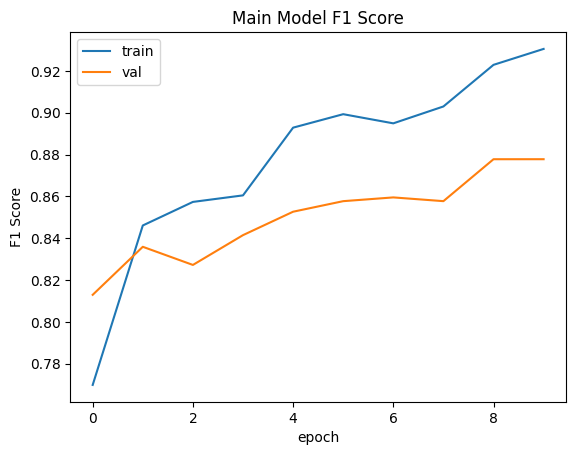

In [ ]:
plt.plot(inceptionv3_augmentation_history.history['fbeta_score'])
plt.plot(inceptionv3_augmentation_history.history['val_fbeta_score'])
plt.title('Main Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

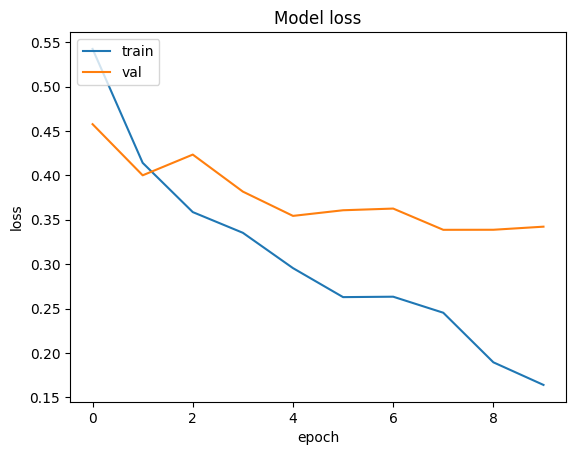

In [ ]:
plt.plot(inceptionv3_augmentation_history.history['loss'])
plt.plot(inceptionv3_augmentation_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Modelo com dataset em HSV

In [ ]:
ds_train_augmentation_hsv = create_dataset(df_train, img_size, batch_size, to_hsv=True, center_crop_height=448, center_crop_width=448)
ds_train_small_augmentation_hsv = create_dataset(df_train_small, img_size, batch_size, to_hsv=True, center_crop_height=448, center_crop_width=448)
ds_val_augmentation_hsv = create_dataset(df_val, img_size, batch_size, to_hsv=True, center_crop_height=448, center_crop_width=448)

In [ ]:
inceptionv3_augmentation_hsv_model = apply_model(InceptionV3, InceptionV3_preprocess, data_augmentation)
start_time = time.time()
inceptionv3_augmentation_hsv_model, inceptionv3_augmentation_hsv_history = apply_train(inceptionv3_augmentation_hsv_model, ds_train_small_augmentation_hsv, ds_val_augmentation_hsv, epochs, callbacks, 'BinaryCrossentropy', lr)
training_time_2 = time.time() - start_time

Epoch 1/10
32/32 [==============================] - 68s 884ms/step - loss: 0.5489 - auc: 0.9089 - fbeta_score: 0.8339 - val_loss: 0.4828 - val_auc: 0.8522 - val_fbeta_score: 0.7875 - lr: 1.0000e-04
Epoch 2/10
32/32 [==============================] - 18s 576ms/step - loss: 0.4837 - auc: 0.8528 - fbeta_score: 0.7964 - val_loss: 0.4828 - val_auc: 0.8552 - val_fbeta_score: 0.7823 - lr: 1.0000e-04
Epoch 3/10
32/32 [==============================] - 15s 464ms/step - loss: 0.4644 - auc: 0.8712 - fbeta_score: 0.8161 - val_loss: 0.4716 - val_auc: 0.8597 - val_fbeta_score: 0.7930 - lr: 1.0000e-04
Epoch 4/10
32/32 [==============================] - 15s 459ms/step - loss: 0.4247 - auc: 0.8915 - fbeta_score: 0.8142 - val_loss: 0.4977 - val_auc: 0.8473 - val_fbeta_score: 0.7731 - lr: 1.0000e-04
Epoch 5/10
32/32 [==============================] - 15s 460ms/step - loss: 0.4438 - auc: 0.8867 - fbeta_score: 0.8342 - val_loss: 0.4450 - val_auc: 0.8778 - val_fbeta_score: 0.8082 - lr: 1.0000e-04
Epoch 6/10

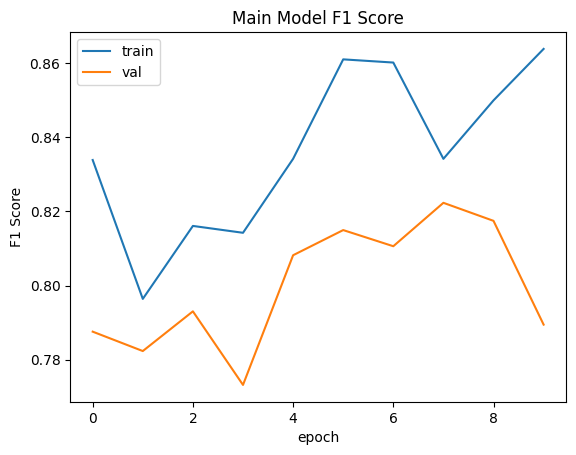

In [ ]:
plt.plot(inceptionv3_augmentation_hsv_history.history['fbeta_score'])
plt.plot(inceptionv3_augmentation_hsv_history.history['val_fbeta_score'])
plt.title('Main Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

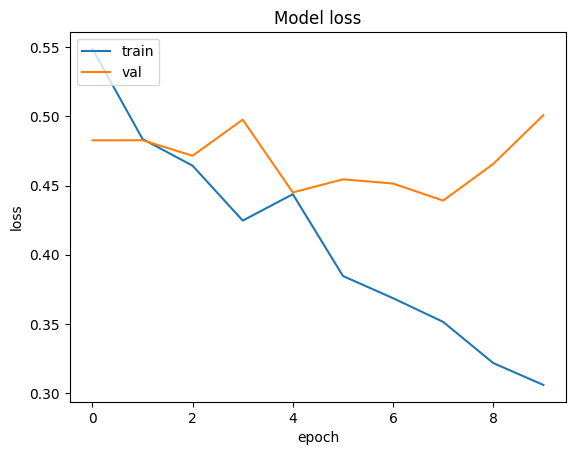

In [ ]:
plt.plot(inceptionv3_augmentation_hsv_history.history['loss'])
plt.plot(inceptionv3_augmentation_hsv_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Comparação entre os dois modelos

In [ ]:
info_df_1 = pd.DataFrame(columns=['Modelo', 'Train F1 Score', 'Val F1 Score', 'Train AUC', 'Val AUC', 'Training Time' ])

info_df_1['Modelo'] = ['Main Model', 'HSV Model']
info_df_1['Train F1 Score'] = [f"{inceptionv3_augmentation_history.history['fbeta_score'][-1] * 100:.2f}%", f"{inceptionv3_augmentation_hsv_history.history['fbeta_score'][-1] * 100:.2f}%"]
info_df_1['Val F1 Score'] = [f"{inceptionv3_augmentation_history.history['val_fbeta_score'][-1] * 100:.2f}%", f"{inceptionv3_augmentation_hsv_history.history['val_fbeta_score'][-1] * 100:.2f}%"]
info_df_1['Train AUC'] = [f"{inceptionv3_augmentation_history.history['auc'][-1] * 100:.2f}%", f"{inceptionv3_augmentation_hsv_history.history['auc'][-1] * 100:.2f}%"]
info_df_1['Val AUC'] = [f"{inceptionv3_augmentation_history.history['val_auc'][-1] * 100:.2f}%", f"{inceptionv3_augmentation_hsv_history.history['val_auc'][-1] * 100:.2f}%"]
info_df_1['Training Time'] = [f"{int(training_time_1)} s", f"{int(training_time_2)} s"]

info_df_1.set_index('Modelo')

,Train F1 Score,Val F1 Score,Train AUC,Val AUC,Training Time
Modelo,,,,,
Main Model,93.05%,87.78%,98.45%,93.29%,240 s
HSV Model,86.39%,78.94%,94.45%,85.84%,252 s


## Treinamento com df_train

Com o aumento do tamanho do dataset, foi necessário a redução do batch_size e o tamanho da imagem para 200, por questões de memória e tempo de treinamento.

In [16]:
ds_train_augmentation_full = create_dataset(df_train, img_size=(200,200), batch_size=4, center_crop_height=448, center_crop_width=448)
ds_val_augmentation_full = create_dataset(df_val, img_size=(200,200), batch_size=4, center_crop_height=448, center_crop_width=448)

In [17]:
ds_train_augmentation_hsv_full = create_dataset(df_train, img_size=(200,200), batch_size=4, to_hsv=True, center_crop_height=448, center_crop_width=448)
ds_val_augmentation_hsv_full = create_dataset(df_val, img_size=(200,200), batch_size=4, to_hsv=True, center_crop_height=448, center_crop_width=448)

### Main Model

In [18]:
inceptionv3_augmentation_full_model = apply_model(InceptionV3, InceptionV3_preprocess, data_augmentation, img_size=(200,200))
start_time = time.time()
inceptionv3_augmentation_full_model, inceptionv3_augmentation_full_history = apply_train(inceptionv3_augmentation_full_model, ds_train_augmentation_full, ds_val_augmentation_full, 15, callbacks, 'BinaryCrossentropy', lr)
training_time_full = time.time() - start_time

Epoch 1/15
1999/1999 [==============================] - 1437s 690ms/step - loss: 0.5011 - auc: 0.8432 - fbeta_score: 0.7735 - val_loss: 0.3911 - val_auc: 0.9132 - val_fbeta_score: 0.8458 - lr: 1.0000e-04
Epoch 2/15
1999/1999 [==============================] - 127s 63ms/step - loss: 0.3922 - auc: 0.9088 - fbeta_score: 0.8471 - val_loss: 0.3681 - val_auc: 0.9264 - val_fbeta_score: 0.8694 - lr: 1.0000e-04
Epoch 3/15
1999/1999 [==============================] - 126s 63ms/step - loss: 0.3512 - auc: 0.9282 - fbeta_score: 0.8709 - val_loss: 0.3099 - val_auc: 0.9406 - val_fbeta_score: 0.8829 - lr: 1.0000e-04
Epoch 4/15
1999/1999 [==============================] - 126s 63ms/step - loss: 0.3318 - auc: 0.9362 - fbeta_score: 0.8817 - val_loss: 0.2905 - val_auc: 0.9504 - val_fbeta_score: 0.8939 - lr: 1.0000e-04
Epoch 5/15
1999/1999 [==============================] - 127s 63ms/step - loss: 0.3183 - auc: 0.9414 - fbeta_score: 0.8852 - val_loss: 0.2686 - val_auc: 0.9587 - val_fbeta_score: 0.8981 - lr:

In [19]:
inceptionv3_augmentation_full_model.save('inceptionv3_augmentation_full_model.h5')

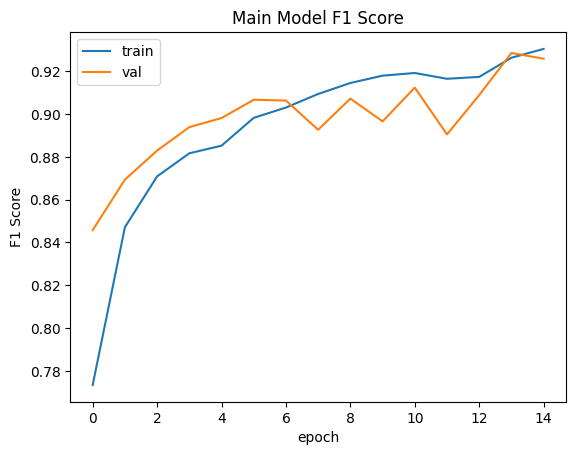

In [20]:
plt.plot(inceptionv3_augmentation_full_history.history['fbeta_score'])
plt.plot(inceptionv3_augmentation_full_history.history['val_fbeta_score'])
plt.title('Main Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

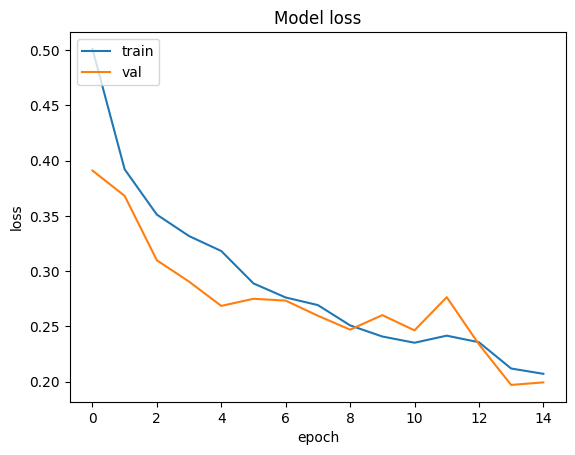

In [21]:
plt.plot(inceptionv3_augmentation_full_history.history['loss'])
plt.plot(inceptionv3_augmentation_full_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### HSV Model

In [18]:
inceptionv3_augmentation_hsv_full_model = apply_model(InceptionV3, InceptionV3_preprocess, data_augmentation, img_size=(200,200))
start_time = time.time()
inceptionv3_augmentation_hsv_full_model, inceptionv3_augmentation_hsv_full_history = apply_train(inceptionv3_augmentation_hsv_full_model, ds_train_augmentation_hsv_full, ds_val_augmentation_hsv_full, 15, callbacks, 'BinaryCrossentropy', lr)
training_time_hsv_full = time.time() - start_time

Epoch 1/15
1999/1999 [==============================] - 254s 100ms/step - loss: 0.5651 - auc: 0.7893 - fbeta_score: 0.7332 - val_loss: 0.4675 - val_auc: 0.8665 - val_fbeta_score: 0.8015 - lr: 1.0000e-04
Epoch 2/15
1999/1999 [==============================] - 131s 66ms/step - loss: 0.5073 - auc: 0.8421 - fbeta_score: 0.7808 - val_loss: 0.4620 - val_auc: 0.8686 - val_fbeta_score: 0.7995 - lr: 1.0000e-04
Epoch 3/15
1999/1999 [==============================] - 129s 65ms/step - loss: 0.4809 - auc: 0.8609 - fbeta_score: 0.8025 - val_loss: 0.4787 - val_auc: 0.8603 - val_fbeta_score: 0.8100 - lr: 1.0000e-04
Epoch 4/15
1999/1999 [==============================] - 132s 66ms/step - loss: 0.4752 - auc: 0.8667 - fbeta_score: 0.8074 - val_loss: 0.4386 - val_auc: 0.8845 - val_fbeta_score: 0.8225 - lr: 1.0000e-04
Epoch 5/15
1999/1999 [==============================] - 127s 63ms/step - loss: 0.4610 - auc: 0.8739 - fbeta_score: 0.8139 - val_loss: 0.4320 - val_auc: 0.8848 - val_fbeta_score: 0.8278 - lr: 

In [19]:
inceptionv3_augmentation_hsv_full_model.save('inceptionv3_augmentation_hsv_full_model.h5')

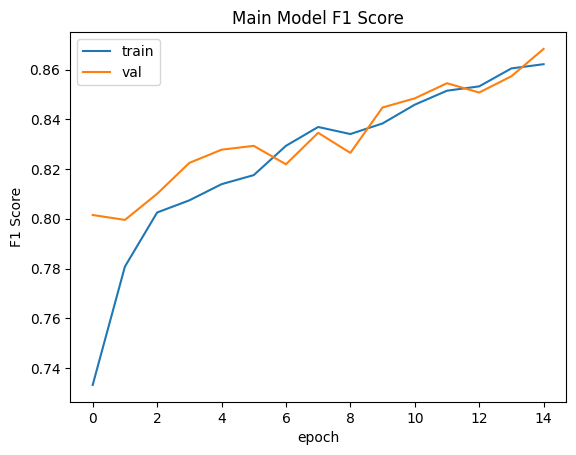

In [20]:
plt.plot(inceptionv3_augmentation_hsv_full_history.history['fbeta_score'])
plt.plot(inceptionv3_augmentation_hsv_full_history.history['val_fbeta_score'])
plt.title('Main Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

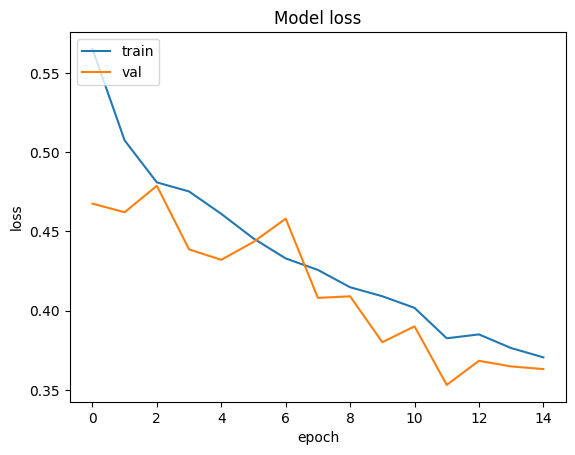

In [21]:
plt.plot(inceptionv3_augmentation_hsv_full_history.history['loss'])
plt.plot(inceptionv3_augmentation_hsv_full_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Retreinamento

Por motivos de memória, optou-se por não realizar o retreinamento com df_train + df_val

### Main Model

In [ ]:
df_train_val = pd.concat([df_train, df_val])
df_train_val_shuffled = df_train_val.sample(frac=1)

In [ ]:
inceptionv3_train_val_model = apply_model(InceptionV3, InceptionV3_preprocess, data_augmentation)
start_time = time.time()
inceptionv3_train_val_model, inceptionv3_train_val_history = apply_train(inceptionv3_train_val_model, ds_train_val, None, 50, callbacks, 'BinaryCrossentropy', lr)
training_time_3 = time.time() - start_time

### HSV Model

In [ ]:
ds_train_val_hsv = create_dataset(df_train_val_shuffled, img_size, batch_size, to_hsv=True, center_crop_height=448, center_crop_width=448)

In [ ]:
inceptionv3_train_val_hsv_model = apply_model(InceptionV3, InceptionV3_preprocess, data_augmentation)
start_time = time.time()
inceptionv3_train_val_hsv_model, inceptionv3_train_val_hsv_history = apply_train(inceptionv3_train_val_hsv_model, ds_train_val_hsv, None, 50, callbacks, 'BinaryCrossentropy', lr)
training_time_4 = time.time() - start_time

## Ensemble Averaging

In [15]:
inceptionv3_augmentation_full_model = load_model('inceptionv3_augmentation_full_model.h5')

In [16]:
inceptionv3_augmentation_hsv_full_model = load_model('inceptionv3_augmentation_hsv_full_model.h5')

In [17]:
pred_main_model = inceptionv3_augmentation_full_model.predict(ds_test_200)
pred_labels_main_model = np.argmax(pred_main_model, axis=1)

334/334 [==============================] - 464s 1s/step


In [18]:
pred_hsv_model = inceptionv3_augmentation_hsv_full_model.predict(ds_test_200_hsv)
pred_labels_hsv_model = np.argmax(pred_hsv_model, axis=1)

334/334 [==============================] - 17s 43ms/step


In [19]:
f1_main_model = f1_score(df_test['label'], pred_labels_main_model, average='weighted')
auc_main_model = roc_auc_score(df_test['label'], pred_labels_main_model)
print(f'Inception V3 main Model F1 Score: {f1_main_model}')
print(f'Inception V3 main Model AUC: {auc_main_model}')

Inception V3 main Model F1 Score: 0.9131511134618989
Inception V3 main Model AUC: 0.9104759532557031


In [20]:
f1_hsv_model = f1_score(df_test['label'], pred_labels_hsv_model, average='weighted')
auc_hsv_model = roc_auc_score(df_test['label'], pred_labels_hsv_model)
print(f'Inception V3 HSV Model F1 Score: {f1_hsv_model}')
print(f'Inception V3 HSV Model AUC: {auc_hsv_model}')

Inception V3 HSV Model F1 Score: 0.860339161999859
Inception V3 HSV Model AUC: 0.8481420075969861


In [21]:
final_pred_model = (pred_main_model + pred_hsv_model) / 2
final_pred_labels = np.argmax(final_pred_model, axis=1)

In [22]:
f1_ensemble_avg = f1_score(df_test['label'], final_pred_labels)
auc_ensemble_avg = roc_auc_score(df_test['label'], final_pred_labels)
print(f'Inception V3 main Model F1 Score: {f1_ensemble_avg}')
print(f'Inception V3 main Model AUC: {auc_ensemble_avg}')

Inception V3 main Model F1 Score: 0.9388209121245829
Inception V3 main Model AUC: 0.9111803869066152


In [23]:
info_df_1 = pd.DataFrame(columns=['Modelo', 'Test F1 Score', 'Test AUC'])

info_df_1['Modelo'] = ['Main Model', 'HSV Model', 'Ensemble Model']
info_df_1['Test F1 Score'] = [f1_main_model, f1_hsv_model, f1_ensemble_avg]
info_df_1['Test AUC'] = [auc_main_model, auc_hsv_model, auc_ensemble_avg]

info_df_1.set_index('Modelo')

,Test F1 Score,Test AUC
Modelo,,
Main Model,0.913151,0.910476
HSV Model,0.860339,0.848142
Ensemble Model,0.938821,0.911180


A métrica F1-Score com average=weighted é a métrica mais convencionalmente utilizada na literatura.

Houve uma melhora significativa no desempenho do modelo com a aplicação do Ensemble Averaging, obtendo um valor final de 93,88% no dataset de teste.

## Avaliação do melhor modelo

### Confusion Matrix

In [24]:
labels = list(map(lambda x: x[1], ds_test_200))
labels = [np.argmax(example, axis=1) for example in labels]
y_test = np.concatenate([l for l in labels], axis=0)
y_pred = np.argmax(final_pred_model, axis=-1).astype('int')

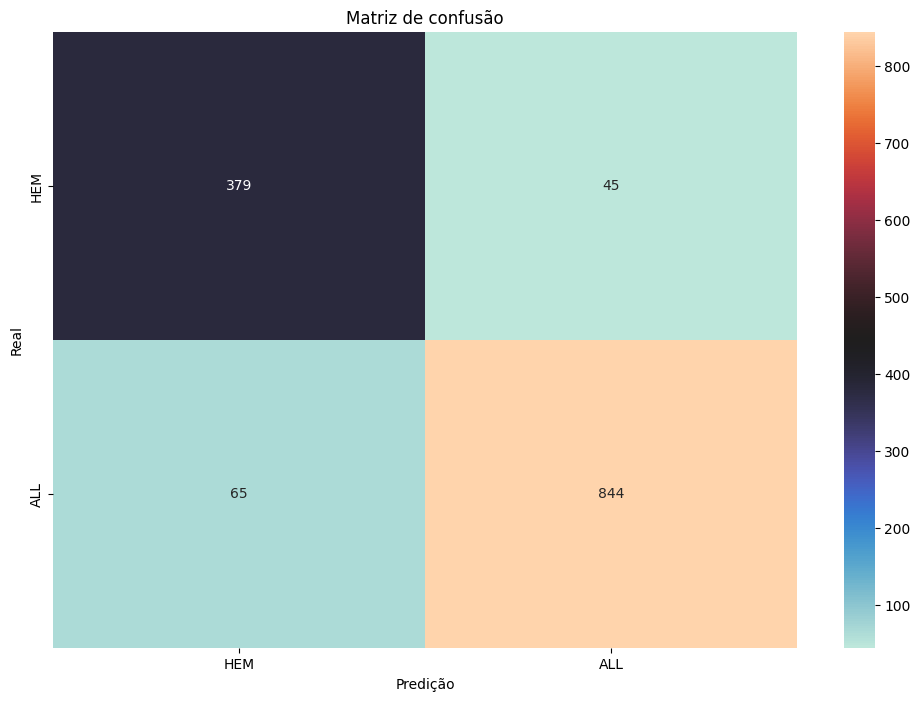

In [25]:
cat_classes = ['HEM', 'ALL']
plot_confusion_matrix(ds_test_200, cat_classes, y_test, final_pred_labels)

Analisando a matriz de confusão acima, pode-se constatar que o modelo ainda realiza classificações equivocadas, principalmente quando a classificação real do glóbulo branco é HEM.

### Imagens erradas

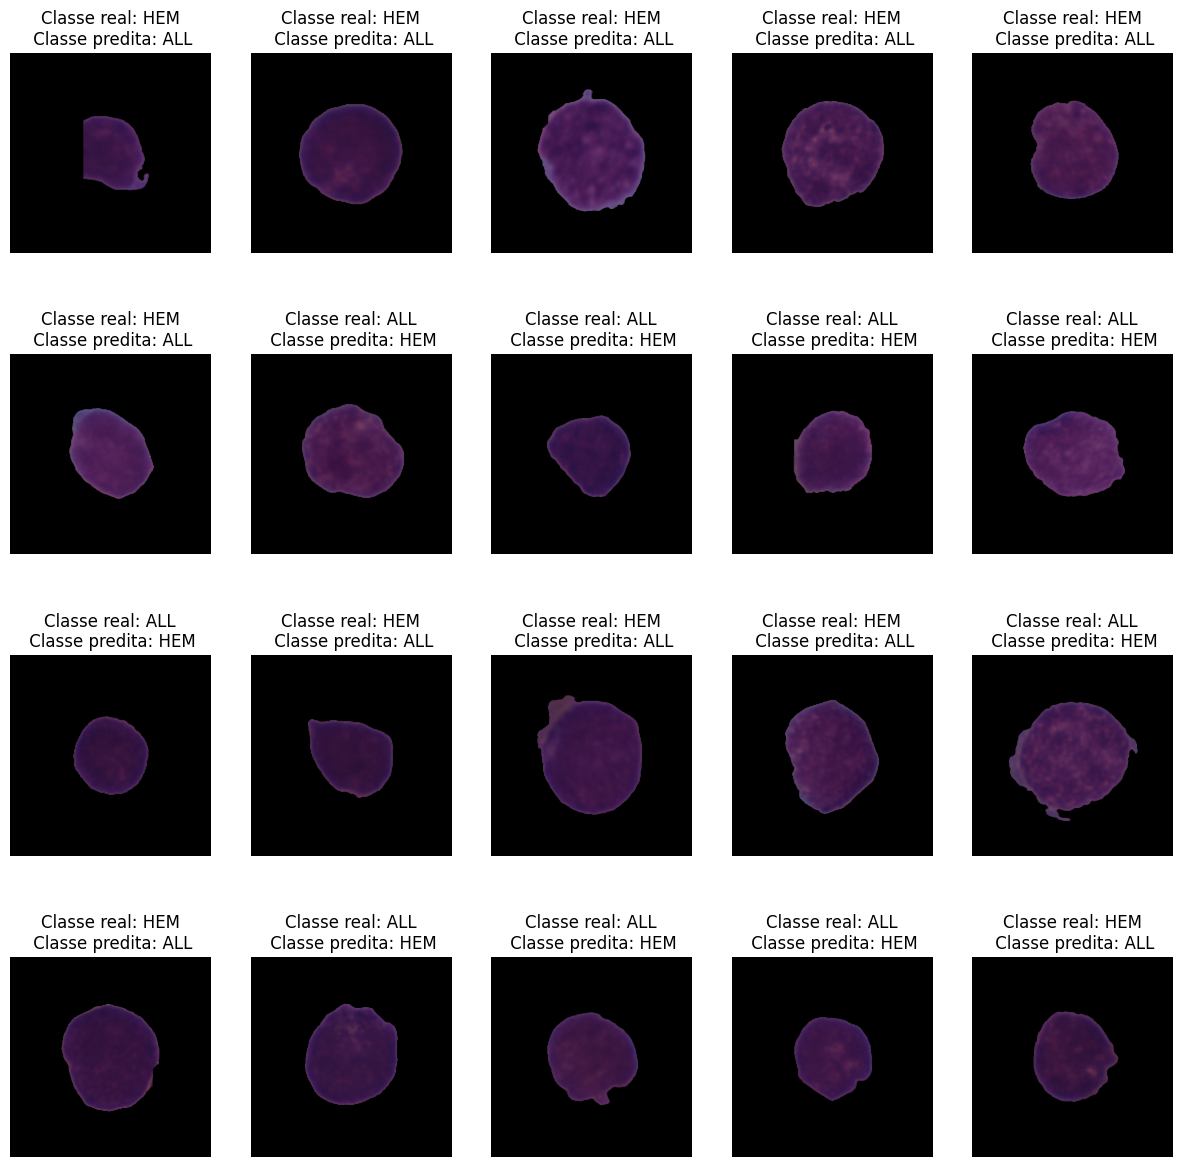

In [26]:
images = list(map(lambda x: x[0], ds_test_200))
images = [example.numpy() for example in images]
X_test = np.concatenate([l for l in images], axis=0)


wrong_images = X_test[y_test != y_pred]
correct_labels = y_test[y_test != y_pred]
incorrect_labels = y_pred[y_test != y_pred]


w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 4
for i in range(1, columns*rows +1):
    img = wrong_images[i - 1]/255
    fig.add_subplot(rows, columns, i)
    if correct_labels[i] == 0:
        correct_label = 'HEM'
    elif correct_labels[i] == 1:
        correct_label = 'ALL'

    if incorrect_labels[i] == 0:
        incorrect_label = 'HEM'
    elif incorrect_labels[i] == 1:
        incorrect_label = 'ALL'

    plt.title(f'Classe real: {correct_label}\n Classe predita: {incorrect_label}')
    plt.imshow(img)
    plt.axis('off')
plt.show()